In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import auth
auth.authenticate_user()

In [4]:
import os
folder_path = '/content/gdrive/MyDrive/DLS/HW4/'
os.chdir(folder_path)

In [5]:
#libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import pickle

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD , Adam
from tensorflow.keras import losses, optimizers
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.layers import Input, InputLayer, Dense, Flatten, LSTM, Dropout, GRU, Conv2D, Lambda, Reshape , Conv2DTranspose , BatchNormalization, UpSampling2D, LeakyReLU , GlobalMaxPooling2D

Q1. RNNs as generative models

In [ ]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
#divide every training image to 16 patches.
patches = np.zeros((X_train.shape[0]*X_train.shape[1]*X_train.shape[2], 7, 7))
patch_nums = np.zeros((X_train.shape[0], 16))
x_train = np.zeros((X_train.shape[0] , 16, 49))

for i in range(X_train.shape[0]):
  img = X_train[i]
  patch_id = 1
  for r in range(0, img.shape[0],7):
    for c in range(0, img.shape[1], 7):
      patch = img[r:r+7, c:c+7]
      patch_nums[i , patch_id-1] = patch_id
      x_train[i , patch_id -1, :] = patch.reshape(-1)
      patch_id += 1

In [ ]:
#divide every testing image to 16 patches.
patches = np.zeros((X_test.shape[0]*X_test.shape[1]*X_test.shape[2], 7, 7))
patch_nums = np.zeros((X_test.shape[0], 16))
x_test = np.zeros((X_test.shape[0] , 16, 49))
x_test.shape
for i in range(X_test.shape[0]):
  img = X_test[i]
  patch_id = 1
  for r in range(0, img.shape[0],7):
    for c in range(0, img.shape[1], 7):
      patch = img[r:r+7, c:c+7]
      patch_nums[i , patch_id-1] = patch_id
      x_test[i , patch_id -1, :] = patch.reshape(-1)
      patch_id += 1

In [ ]:
 x_train.shape , x_test.shape

((60000, 16, 49), (10000, 16, 49))

In [ ]:
x_train[: , :15, :].shape , x_train[: , 1:16, :].shape

((60000, 15, 49), (60000, 15, 49))

In [ ]:
#rnn model
batch_size  = 100
model = tf.keras.Sequential([
    Input(batch_shape = (batch_size, 15, 49)),
    LSTM(64 , return_sequences = True),
    LSTM(64 , return_sequences = True),
    Dense(49,  activation = 'sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (100, 15, 64)             29184     
                                                                 
 lstm_1 (LSTM)               (100, 15, 64)             33024     
                                                                 
 dense (Dense)               (100, 15, 49)             3185      
                                                                 
Total params: 65393 (255.44 KB)
Trainable params: 65393 (255.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam' , loss = "mse" , metrics = ['accuracy'])

In [ ]:
#take input for all patches except last one
#compare your output with patches between 2:16 except last one.
history = model.fit(x_train[: , :15, :], x_train[: , 1:16, :], validation_data = (x_test[: , :15, :] , x_test[: , 1:16 ,:]) ,batch_size = 100 , epochs = 50)

Epoch 1/50
600/600 [==============================] - 22s 31ms/step - loss: 0.0898 - accuracy: 0.1244 - val_loss: 0.0650 - val_accuracy: 0.2155
Epoch 2/50
600/600 [==============================] - 16s 26ms/step - loss: 0.0589 - accuracy: 0.2073 - val_loss: 0.0546 - val_accuracy: 0.2305
Epoch 3/50
600/600 [==============================] - 16s 26ms/step - loss: 0.0518 - accuracy: 0.2112 - val_loss: 0.0488 - val_accuracy: 0.2057
Epoch 4/50
600/600 [==============================] - 16s 27ms/step - loss: 0.0470 - accuracy: 0.1959 - val_loss: 0.0451 - val_accuracy: 0.2010
Epoch 5/50
600/600 [==============================] - 16s 27ms/step - loss: 0.0439 - accuracy: 0.1987 - val_loss: 0.0424 - val_accuracy: 0.2069
Epoch 6/50
600/600 [==============================] - 16s 27ms/step - loss: 0.0416 - accuracy: 0.2072 - val_loss: 0.0404 - val_accuracy: 0.2146
Epoch 7/50
600/600 [==============================] - 16s 27ms/step - loss: 0.0399 - accuracy: 0.2117 - val_loss: 0.0388 - val_accuracy:

In [ ]:
model.save('/content/gdrive/MyDrive/DLS/HW4/rnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


plotting one digit

In [ ]:
#generative model for a test image
#divide test image to 16 patches
img = X_test[1]
test_patch = []
patch_id = 1
for r in range(0, img.shape[0],7):
  for c in range(0, img.shape[1], 7):
    patch = img[r:r+7, c:c+7]
    patch = patch.reshape(-1)
    test_patch.append(patch)

test_patch = np.stack(test_patch)

In [ ]:
y_test[1]

2

In [ ]:
test_patch.shape , test_patch[:8].shape

((16, 49), (8, 49))

In [ ]:
def pad_patches(patches , length):
  patch_len, patch_size = patches.shape
  num_padding = length - patch_len
  padded = np.full((num_padding, patch_size), 0 )
  return np.concatenate([patches, padded], axis=0)

In [ ]:
#take only 8 patches and pad 0 so that we can feed it to the model
test = pad_patches(test_patch[:8] , 15)
test.shape
test = np.expand_dims(test , 0)
test.shape

(1, 15, 49)

In [ ]:
#feed first 8 patches to the trained model
model = load_model('/content/gdrive/MyDrive/DLS/HW4/rnn1.h5')

In [ ]:
#run model frame by frame
predicted_patches = []
input_sequence = test_patch[:8]
input_sequence = pad_patches(input_sequence, 15 )
input_sequence = np.expand_dims(input_sequence, 0)
print(input_sequence.shape)
#predict for the next 8 patches

for i in range(8):
  #print(input_sequence.shape)
  pred = model.predict(input_sequence)
  top_half = input_sequence[:, :i+8]
  bottom_half = pred[:,i+7:i+8]
  #print(bottom_half.shape, top_half.shape)
  input_sequence = np.concatenate([top_half, bottom_half], axis = 1)
  #print(input_sequence.shape)b
  if i == 7:
    print(input_sequence.shape)
    break
  input_sequence = np.pad(input_sequence, [(0, 0), (0, 6-i), (0, 0)], 'constant', constant_values=0)
  #print(input_sequence.shape)


(1, 15, 49)
1/1 [==============================] - 0s 22ms/step
(1, 16, 49)


In [ ]:
predicted_patches.append(input_sequence)

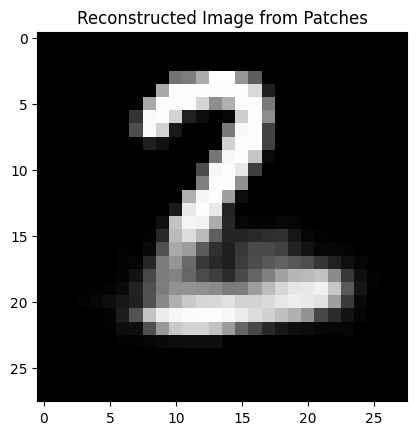

In [ ]:
#reshape patches to be compatible with the image
patches_reshaped = predicted_patches[0].reshape((predicted_patches[0].shape[0], 4, 4, 7, 7))
patches_reshaped.shape

#combine patches to form the full image
reconstructed_images = []
for i in range(patches_reshaped.shape[0]):
    image_patches = []
    for j in range(4):
        row_patches = []
        for k in range(4):
            patch_index = int(patch_nums[i, j * 4 + k]) - 1
            row_patches.append(patches_reshaped[i, j, k])
        image_patches.append(np.concatenate(row_patches, axis=1))
    reconstructed_images.append(np.concatenate(image_patches, axis=0))

reconstructed_images = np.array(reconstructed_images)

# Plot the reconstructed image
plt.imshow(reconstructed_images[0], cmap='gray')  # Assuming it's a grayscale image
plt.title('Reconstructed Image from Patches')
plt.show()


plot 10 digits from 10 classes

In [ ]:
re = []
imgs = []

for digit in range(10):
    #first 10 occurrences of the current digit in the test set
    digit_indices = np.where(y_test == digit)[0][:10]

    for idx in digit_indices:
        img = X_test[idx]
        imgs.append(img)

        #test patch
        test_patch = []
        patch_id = 1
        for r in range(0, img.shape[0],7):
          for c in range(0, img.shape[1], 7):
            patch = img[r:r+7, c:c+7]
            patch = patch.reshape(-1)
            test_patch.append(patch)

        test_patch = np.stack(test_patch)

        #run model frame by frame
        predicted_patches = []
        input_sequence = test_patch[:8]
        input_sequence = pad_patches(input_sequence, 15)
        input_sequence = np.expand_dims(input_sequence, 0)

        #predict for the next 8 patches
        for i in range(8):
            pred = model.predict(input_sequence)
            top_half = input_sequence[:, :i + 8]
            bottom_half = pred[:, i + 7:i + 8]
            input_sequence = np.concatenate([top_half, bottom_half], axis=1)

            if i == 7:
                break
            input_sequence = np.pad(input_sequence, [(0, 0), (0, 6 - i), (0, 0)], 'constant', constant_values=0)

        #reshape patches to be compatible with the image
        predicted_patches.append(input_sequence)
        patches_reshaped = predicted_patches[0].reshape((predicted_patches[0].shape[0], 4, 4, 7, 7))

        #combine patches to form the full image
        reconstructed_images = []
        for i in range(patches_reshaped.shape[0]):
            image_patches = []
            for j in range(4):
                row_patches = []
                for k in range(4):
                    patch_index = int(patch_nums[i, j * 4 + k]) - 1
                    row_patches.append(patches_reshaped[i, j, k])
                image_patches.append(np.concatenate(row_patches, axis=1))
            reconstructed_images.append(np.concatenate(image_patches, axis=0))

        reconstructed_images = np.array(reconstructed_images)
        re.append(reconstructed_images)

1/1 [==============================] - 0s 25ms/step


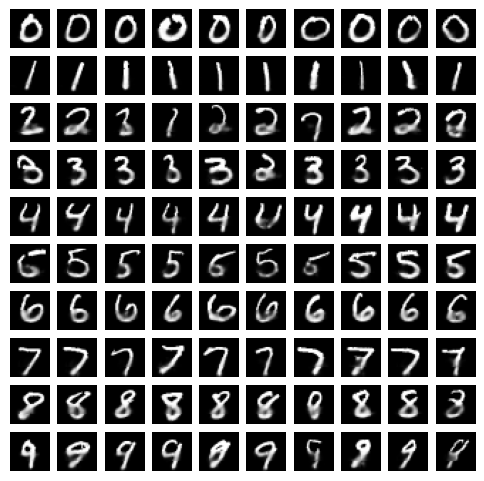

In [ ]:
#plot of generated images
num_images = 100
fig, axs = plt.subplots(10 ,10, figsize=(6, 6))

for i in range(num_images):
    row = i // 10
    col = i % 10
    axs[row, col].imshow(re[i][0], cmap='gray')
    axs[row, col].axis('off')
plt.show()

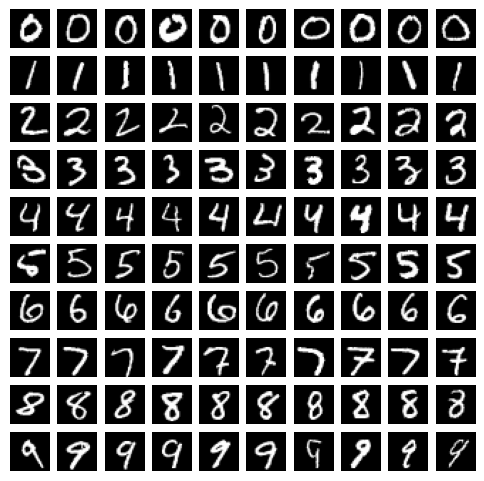

In [ ]:
#plot of original images
num_images = 100
fig, axs = plt.subplots(10 ,10 , figsize=(6, 6))

for i in range(num_images):
    row = i // 10
    col = i % 10
    axs[row, col].imshow(imgs[i], cmap='gray')
    axs[row, col].axis('off')

plt.show()

Q2. VAE on Poor Sevens.

In [ ]:
#tr7.pkl 6265 x 28 x 28 images
#te7.pkl 1028 x 28 x 28
#different from orignal 7 in mnist - special effect

In [ ]:
train = pickle.load(open('tr7.pkl', 'rb'))
test = pickle.load(open('te7.pkl', 'rb'))

In [ ]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

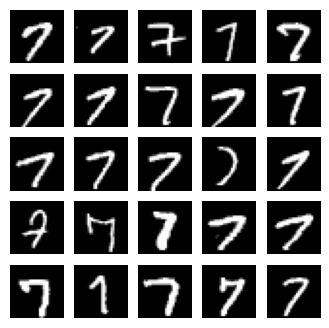

In [ ]:
#display original 7 digit of mnist dataset
digit_seven_indices = np.where(y_train == 7)[0]
digit_seven_images = X_train[digit_seven_indices]

num_images = 25
fig, axs = plt.subplots(5 ,5 , figsize=(4, 4))
digit_7 = digit_seven_images[:num_images]

for i in range(num_images):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(digit_7[i], cmap='gray')
    axs[row, col].axis('off')

plt.show()

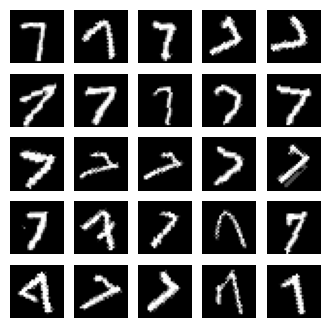

In [ ]:
#display train images of the effect added 7 digit
num_images = 25
fig, axs = plt.subplots(5 ,5 , figsize=(4, 4))

for i in range(num_images):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(train[i], cmap='gray')
    axs[row, col].axis('off')

plt.show()

In [ ]:
train.shape , test.shape

((6265, 28, 28), (1028, 28, 28))

In [ ]:
train_data = train/255.0
test_data = test/255.0

In [ ]:
#reshape
train_data = train_data.reshape(-1, 784)
test_data = test_data.reshape(-1, 784)

In [ ]:
train_data.shape , test_data.shape

((6265, 784), (1028, 784))

In [ ]:
#latent dimension
latent_dim = 3

In [ ]:
#sampling from a normal distribution
#reparameterization. Instead of sampling from Q(z|X), sample epsilon = N(0,I) z = z_mean + sqrt(var)*eps.
def sampling(args):
  z_mean , z_log_var = args
  epsilon = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
  z = z_mean + tf.exp(z_log_var / 2) * epsilon
  return z

In [ ]:
#encoder
input = Input(shape = (784,) , name = 'input')
x = Dense(512, activation='relu')(input)
z_mean = Dense(latent_dim , name = 'z_mean')(x)
z_log_var = Dense(latent_dim , name = 'z_log_var')(x)

In [ ]:
#sampling layer
z = Lambda(sampling, name = 'z')([z_mean , z_log_var])
encoder = tf.keras.Model(input, [z_mean, z_log_var, z] , name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 784)]                0         []                            
                                                                                                  
 dense_29 (Dense)            (None, 512)                  401920    ['input[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 3)                    1539      ['dense_29[0][0]']            
                                                                                                  
 z_log_var (Dense)           (None, 3)                    1539      ['dense_29[0][0]']            
                                                                                            

In [ ]:
#decoder
latent_output = Input(shape=(latent_dim,) , name = 'z_sampling')
decoder_input = Dense(512, activation='relu')(latent_output)
decoder_output = Dense(784, activation='sigmoid')(decoder_input)
decoder = tf.keras.Model(latent_output, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 3)]               0         
                                                                 
 dense_30 (Dense)            (None, 512)               2048      
                                                                 
 dense_31 (Dense)            (None, 784)               402192    
                                                                 
Total params: 404240 (1.54 MB)
Trainable params: 404240 (1.54 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#vae model
output = decoder(encoder(input)[2])
vae = tf.keras.Model(input, output, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 3),               404998    
                              (None, 3),                         
                              (None, 3)]                         
                                                                 
 decoder (Functional)        (None, 784)               404240    
                                                                 
Total params: 809238 (3.09 MB)
Trainable params: 809238 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
recon_loss = K.sum(K.binary_crossentropy(K.flatten(input), K.flatten(output)), axis=-1)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(recon_loss + kl_loss)

In [ ]:
vae.add_loss(vae_loss)
vae.compile(optimizer = 'Adam' , metrics = ['accuracy'])

In [ ]:
#fit model
history = vae.fit(x = train_data ,y = train_data, epochs= 50, batch_size= 16, validation_data = (test_data, test_data))

Epoch 1/50
392/392 [==============================] - 12s 25ms/step - loss: 684.0330 - accuracy: 0.0048 - val_loss: 83.1660 - val_accuracy: 0.0058
Epoch 2/50
392/392 [==============================] - 10s 25ms/step - loss: 73.7325 - accuracy: 0.0059 - val_loss: 64.0082 - val_accuracy: 0.0049
Epoch 3/50
392/392 [==============================] - 6s 16ms/step - loss: 59.0480 - accuracy: 0.0065 - val_loss: 54.0050 - val_accuracy: 0.0058
Epoch 4/50
392/392 [==============================] - 6s 15ms/step - loss: 52.3956 - accuracy: 0.0051 - val_loss: 49.8574 - val_accuracy: 0.0049
Epoch 5/50
392/392 [==============================] - 7s 18ms/step - loss: 49.2961 - accuracy: 0.0069 - val_loss: 47.7601 - val_accuracy: 0.0078
Epoch 6/50
392/392 [==============================] - 5s 13ms/step - loss: 47.6025 - accuracy: 0.0072 - val_loss: 46.3563 - val_accuracy: 0.0078
Epoch 7/50
392/392 [==============================] - 6s 16ms/step - loss: 46.2744 - accuracy: 0.0065 - val_loss: 45.3299 - val

In [ ]:
vae.save('/content/gdrive/MyDrive/DLS/HW4/vae2.h5')

In [ ]:
vae = load_model('/content/gdrive/MyDrive/DLS/HW4/vae2.h5')

1/1 [==============================] - 0s 98ms/step


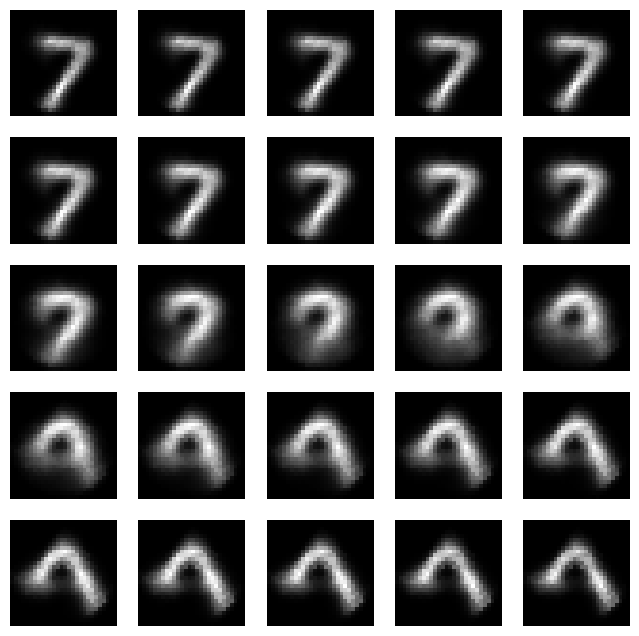

In [ ]:
num_samples = 25
latent_dim = 3

varying_values = np.linspace(-3, 3, num_samples)

fig, axs = plt.subplots(5, 5, figsize=(8, 8))

for i, value in enumerate(varying_values):
    #latent vector with a single value
    fixed_values = np.zeros(latent_dim)
    fixed_values[0] = value
    manipulated_latent_vector = np.expand_dims(fixed_values, axis=0)

    #decode the manipulated latent vector to generate images
    generated_images = decoder.predict(manipulated_latent_vector)
    generated_images = generated_images.reshape((28, 28))

    #display the generated images
    row = i // 5
    col = i % 5
    axs[row , col].imshow(generated_images, cmap='gray')
    axs[row, col].axis('off')

plt.show()

As we can see by plotting the generated images, we can say that the 7's are rotated.

Q3. Conditional GAN

In [ ]:
#generator - generates fake images
#discriminator - classify as real or fake
#Conditional GAN - condition generation of images.

In [98]:
#load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [99]:
#scale -1 to 1
x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

In [100]:
#One hot vectors
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 10)

In [106]:
#generator
def build_generator():
  generator = tf.keras.Sequential()
  noise = Input(shape = (100, ))
  label = Input(shape = (10, ))

  # x = tf.keras.layers.Concatenate()([noise, label])
  # x = Dense(512, activation='relu')(x)
  # x = Dense(512, activation='relu')(x)
  # x = Dense(1024 , activation = 'relu')(x)
  # x = Dense(784, activation='tanh')(x)

  x = tf.keras.layers.Concatenate()([noise, label])
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dense(512, activation='relu')(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dense(1024, activation='relu')(x)
  x = BatchNormalization(momentum = 0.8)(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Dense(784, activation='tanh')(x)

  generator = tf.keras.Model([noise, label], x)
  generator.summary()
  return generator

In [102]:
#discriminator
def build_discriminator():
  image_input = Input(shape = (784))
  label_input = Input(shape = (10, ))

  x = tf.keras.layers.Concatenate()([image_input , label_input])
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(1, activation='sigmoid')(x)

  discriminator = tf.keras.Model([image_input, label_input], x)
  discriminator.summary()
  return discriminator

In [107]:
#compile gen and discriminative models
generator = build_generator()
generator.compile(optimizer = Adam(learning_rate = 0.0001, beta_1 = 0.5), loss = 'binary_crossentropy', metrics = ['accuracy'])

discriminator = build_discriminator()
discriminator.compile(optimizer = Adam(learning_rate = 0.0001 , beta_1 = 0.5), loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_1 (Concatenate  (None, 110)                  0         ['input_31[0][0]',            
 )                                                                   'input_32[0][0]']            
                                                                                                  
 dense_52 (Dense)            (None, 512)                  56832     ['concatenate_1[0][0]']   

In [108]:
#gan model

#gan input
gan_input_noise = Input(shape=(100,))
gan_input_label = Input(shape=(10,))
generated_img = generator([gan_input_noise, gan_input_label])

#gan output
#freeze the weights of the discriminator layer
discriminator.trainable = False
gan_output = discriminator([generated_img, gan_input_label])

gan = tf.keras.Model(inputs=[gan_input_noise, gan_input_label], outputs=gan_output)
gan.compile(optimizer = Adam(learning_rate = 0.0001 , beta_1 = 0.5), loss='binary_crossentropy', metrics=['accuracy'])
gan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_36 (InputLayer)       [(None, 10)]                 0         []                            
                                                                                                  
 model (Functional)          (None, 784)                  1656592   ['input_35[0][0]',            
                                                                     'input_36[0][0]']            
                                                                                                  
 model_1 (Functional)        (None, 1)                    1470465   ['model[0][0]',         

In [109]:
epochs = 50
batch_size = 128

d_accuracy_real = []
d_accuracy_fake = []

for epoch in range(epochs):

    for i in range(len(x_train) // batch_size):
      #real examples
      idx = np.random.randint(0, x_train.shape[0], batch_size)
      real_images, real_labels = x_train[idx], y_train_one_hot[idx]
      fake_labels = np.eye(10)[np.random.choice(10, batch_size)]

      #generate fake examples
      noise = np.random.normal(0, 1, (batch_size, 100))
      generated_images = generator.predict([noise, real_labels])

      #train discriminator
      real_labels_discriminator = np.ones((batch_size, 1))
      fake_labels_discriminator = np.zeros((batch_size, 1))

      #train discriminator on real and fake images
      d_loss_real  = discriminator.train_on_batch([real_images.reshape(batch_size, -1), real_labels], real_labels_discriminator)
      d_loss_fake  = discriminator.train_on_batch([generated_images.reshape(batch_size, -1), fake_labels], fake_labels_discriminator)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #train generator
      noise = np.random.normal(0, 1, (batch_size, 100))
      valid_labels = np.ones((batch_size, 1))

      g_loss = gan.train_on_batch([noise, fake_labels], valid_labels)

    #classification accuracy of real and fake examples
    d_accuracy_real.append(d_loss_real[1])
    d_accuracy_fake.append(d_loss_fake[1])

    print(f"Epoch {epoch + 1}, [D loss: {d_loss[0]}, accuracy: {100 * d_loss[1]}] [G loss: {g_loss[0]}, accuracy: {100 * g_loss[1]}]")

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 2ms/step
Epoch 40, [D loss: 0.21352843940258026, accuracy: 92.578125] [G loss: 0.15943191945552826, accuracy: 100.0]
4/4 [==============================] - 0s 2ms/step
Epoch 41, [D loss: 0.14469974488019943, accuracy: 94.921875] [G loss: 0.15371043980121613, accuracy: 100.0]
4/4 [==============================] - 0s 2ms/step
Epoch 42, [D loss: 0.12412097305059433, accuracy: 96.875] [G loss: 0.19511251151561737, accuracy: 98.4375]
4/4 [==============================] - 0s 2ms/step
Epoch 43, [D loss: 0.205587238073349, accuracy: 92.578125] [G loss: 0.13600221276283264, accuracy: 100.0]
4/4 [==============================] - 0s 2ms/step
Epoch 44, [D loss: 0.16693293303251266, accuracy: 94.140625] [G loss: 0.18086197972297668, accuracy: 98.4375]
4/4 [==============================] - 0s 2ms/step
Epoch 45, [D loss: 0.13207755610346794, accuracy: 96.484375] [G loss: 0.13636326789855957, accuracy: 100

4/4 [==============================] - 0s 3ms/step


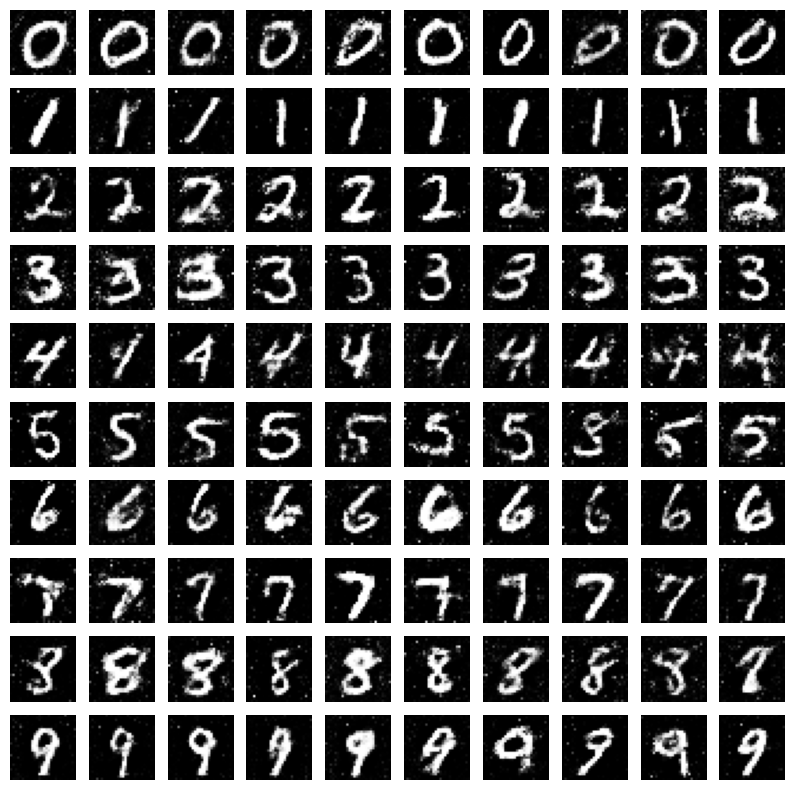

In [110]:
#plot generated images

#number of examples per class
num = 10

#generate test examples
noise = np.random.normal(0, 1, (num * 10, 100))
sampled_labels = np.repeat(np.arange(10), num)
one_hot_labels = tf.keras.utils.to_categorical(sampled_labels, num_classes=10)
generated_images = generator.predict([noise, one_hot_labels])

generated_images = generated_images.reshape((10, num, *generated_images.shape[1:]))
generated_images.shape

#plot
fig, axs = plt.subplots(10, num, figsize=(10, 10))

for i in range(10):
    for j in range(num):
        axs[i, j].imshow(generated_images[i, j].reshape(28, 28), cmap='gray')
        axs[i, j].axis('off')

plt.show()

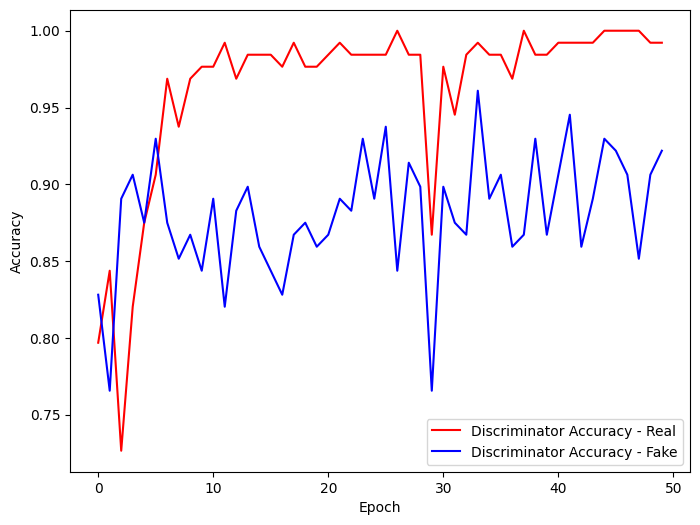

In [111]:
#plot of convergence graph
plt.figure(figsize=(8, 6))
plt.plot(d_accuracy_real, label='Discriminator Accuracy - Real', color = 'red')
plt.plot(d_accuracy_fake, label='Discriminator Accuracy - Fake', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Q4. Missing Value Imputation Using Conditional GAN

In [ ]:
#assume the center patch is given generator will predict the surroudning pixels

In [59]:
#load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

In [60]:
#extract center patch from image
def extract_center_patch(img, patch_size=10):
    patch = img[: , 9:19 , 9:19]
    patch_flatten = patch.reshape((patch.shape[0], -1))
    return patch_flatten

In [138]:
#generator
#take the center 10x 10 - flatten it - conditioning vector - B X 100
#generator takes in 200 dimensional vector and generates MNIST like images

def build_generator(latent_dim):
  model = tf.keras.models.Sequential()
  model.add(InputLayer(input_shape=(latent_dim + 100,)))
  model.add(Dense(512, activation='relu'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dense(512, activation='relu'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dense(1024, activation='relu'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dense(784, activation='tanh'))
  model.add(Reshape((28, 28)))

  # model = tf.keras.models.Sequential()
  # model.add(InputLayer(input_shape=(latent_dim + 100,)))
  # model.add(Dense(512, activation='relu'))
  # model.add(BatchNormalization(momentum = 0.8))
  # model.add(LeakyReLU(alpha = 0.2))
  # model.add(Dense(512, activation='relu'))
  # model.add(BatchNormalization(momentum = 0.8))
  # model.add(LeakyReLU(alpha = 0.2))
  # model.add(Dense(1024, activation='relu'))
  # model.add(BatchNormalization(momentum = 0.8))
  # model.add(LeakyReLU(alpha = 0.2))
  # model.add(Dense(784, activation='tanh'))
  # model.add(Reshape((28, 28)))

  # model = tf.keras.models.Sequential()
  # model.add(Input(shape=(latent_dim + 100,)))
  # model.add(Dense(7 * 7 * 200, activation='relu'))
  # model.add(LeakyReLU(alpha = 0.2))
  # model.add(Reshape((7, 7, 200)))
  # model.add(Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same'))
  # model.add(LeakyReLU(alpha = 0.2))
  # model.add(Conv2DTranspose(128, (4, 4), strides = 2, padding = 'same'))
  # model.add(LeakyReLU(alpha = 0.2))
  # model.add(Conv2D(1 , (7, 7), padding = "same" , activation = "tanh"))
  # model.add(Reshape((28, 28)))

  # model = tf.keras.models.Sequential()
  # model.add(InputLayer(input_shape=(latent_dim + 100,)))
  # model.add(tf.keras.layers.Dense(128*7*7, activation='relu'))
  # model.add(tf.keras.layers.Reshape((7,7,128)))
  # model.add(tf.keras.layers.UpSampling2D())
  # model.add(tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'))
  # model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  # model.add(tf.keras.layers.UpSampling2D())
  # model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'))
  # model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  # model.add(tf.keras.layers.Conv2D(1,3,padding='same',activation='tanh'))
  # model.add(Reshape((28, 28)))

  return model

In [135]:
#discriminator
def build_discriminator():
  model = tf.keras.models.Sequential()
  model.add(InputLayer(input_shape=(28, 28)))
  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(512, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  # model = tf.keras.models.Sequential()
  # model.add(Input(shape=(28, 28, 1)))
  # model.add(Conv2D(64, (3, 3), strides=2, padding='same'))
  # model.add(LeakyReLU(alpha = 0.2))
  # model.add(Conv2D(128, (3, 3), strides=2, padding='same'))
  # model.add(LeakyReLU(alpha = 0.2))
  # model.add(GlobalMaxPooling2D())
  # model.add(Dense(1, activation='sigmoid'))

  # model = tf.keras.models.Sequential()
  # model.add(Input(shape=(28, 28)))
  # model.add(Reshape((28, 28, 1)))
  # model.add(tf.keras.layers.Conv2D(32,(3,3),2,padding='same'))
  # model.add(tf.keras.layers.LeakyReLU(0.2))
  # model.add(tf.keras.layers.Dropout(0.25))
  # model.add(tf.keras.layers.Conv2D(64,(3,3),2,padding='same'))
  # model.add(tf.keras.layers.LeakyReLU(0.2))
  # model.add(tf.keras.layers.Dropout(0.25))
  # model.add(tf.keras.layers.Flatten())
  # model.add(tf.keras.layers.Dense(512, activation='relu'))
  # model.add(tf.keras.layers.Dropout(0.25))
  # model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  return model

In [139]:
def build_gan(generator, discriminator):
  discriminator.trainable = False
  model = tf.keras.models.Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [140]:
latent_dim = 100
generator = build_generator(latent_dim)
generator.compile(optimizer = Adam(learning_rate = 0.0001), loss = "binary_crossentropy", metrics=['accuracy'])
generator.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 512)               102912    
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_81 (Dense)            (None, 512)               262656    
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_82 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_83 (Dense)            (None, 784)             

In [141]:
discriminator = build_discriminator()
discriminator.compile(optimizer= Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 784)               0         
                                                                 
 dense_84 (Dense)            (None, 1024)              803840    
                                                                 
 dropout_36 (Dropout)        (None, 1024)              0         
                                                                 
 dense_85 (Dense)            (None, 512)               524800    
                                                                 
 dropout_37 (Dropout)        (None, 512)               0         
                                                                 
 dense_86 (Dense)            (None, 256)               131328    
                                                                 
 dropout_38 (Dropout)        (None, 256)             

In [142]:
gan = build_gan(generator, discriminator)
gan.compile(optimizer = Adam(learning_rate = 0.0001), loss='binary_crossentropy')

In [143]:
conditioning_vectors = extract_center_patch(x_train)

In [144]:
conditioning_vectors.shape

(60000, 100)

In [145]:
#for gan with lambda = 1
lambda_value = 0.1
batch_size = 128
epochs = 10

for epoch in range(epochs):

  for _ in range(len(x_train) // batch_size):
    #generate random noise and concatenate with conditioning vectors
    random_noise = np.random.normal(0, 1, (batch_size, latent_dim))
    combined_input = np.concatenate([random_noise, conditioning_vectors[:batch_size]] , axis = 1)
    #generate fake images
    generated_images = generator.predict(combined_input)

    #minibatch with both real and fake images
    real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    #train discriminator
    d_images = np.concatenate([real_images , generated_images] , axis = 0)
    d_labels = np.concatenate([labels_real , labels_fake] , axis = 0)
    d_loss = discriminator.train_on_batch(d_images, d_labels)
    #d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    #d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

    #train generator
    random_noise = np.random.normal(0, 1, (batch_size, latent_dim))
    combined_input = np.concatenate([random_noise, conditioning_vectors[:batch_size]] , axis = 1)
    labels_gan = np.ones((batch_size, 1))
    gen_center = generated_images[:, 9:19, 9:19].reshape(batch_size, 100)
    g_loss = gan.train_on_batch(combined_input, labels_gan) + lambda_value * K.mean(K.square(conditioning_vectors[:batch_size] - gen_center))

  print(f"Epoch {epoch}, D Loss Real: {d_loss}, G Loss: {g_loss}")

4/4 [==============================] - 0s 2ms/step
Epoch 0, D Loss Real: [0.2886601984500885, 0.90234375], G Loss: 4.427452465731257
4/4 [==============================] - 0s 2ms/step
Epoch 1, D Loss Real: [0.1189236044883728, 0.953125], G Loss: 4.981463371935491
4/4 [==============================] - 0s 2ms/step
Epoch 2, D Loss Real: [0.029057197272777557, 0.99609375], G Loss: 6.695886705857966
4/4 [==============================] - 0s 2ms/step
Epoch 3, D Loss Real: [0.157804474234581, 0.94140625], G Loss: 4.834691633157843
4/4 [==============================] - 0s 2ms/step
Epoch 4, D Loss Real: [0.09847145527601242, 0.96875], G Loss: 6.188377471080614
4/4 [==============================] - 0s 2ms/step
Epoch 5, D Loss Real: [0.03473764657974243, 0.9921875], G Loss: 4.904138328379332
4/4 [==============================] - 0s 2ms/step
Epoch 6, D Loss Real: [0.05969824269413948, 0.984375], G Loss: 4.202820566993671
4/4 [==============================] - 0s 2ms/step
Epoch 7, D Loss Real: 

1/1 [==============================] - 0s 22ms/step


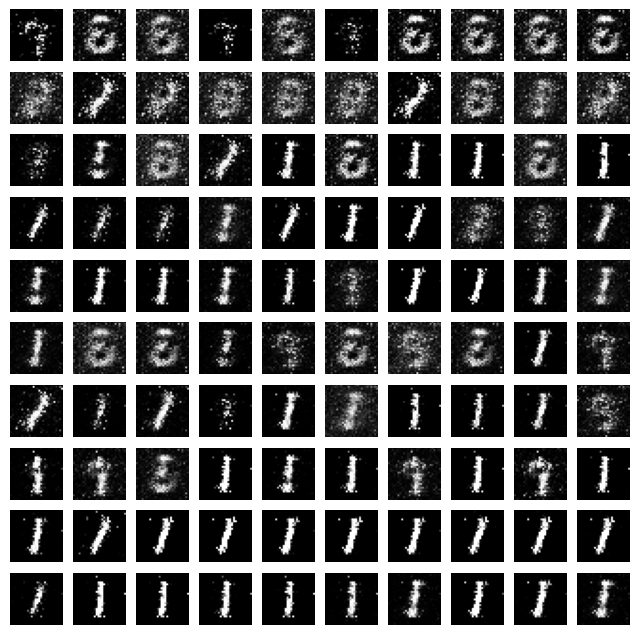

In [146]:
#generate images

num = 10
fig, axs = plt.subplots(10, num, figsize=(8, 8))

for i in range(10):
    original_images = x_test[y_test == i][:num]
    conditioning_vector = extract_center_patch(original_images)

    random_noise = np.random.normal(0, 1, (num, latent_dim))

    combined_input_example = np.concatenate([random_noise, conditioning_vector], axis=1)
    generated_images = generator.predict(combined_input_example)

    #generated images
    for j in range(num):
        axs[i, j].imshow(generated_images[j].reshape(28, 28), cmap='gray')
        axs[i, j].axis('off')

    #original images
    # for j in range(num):
    #     axs[i, num + j].imshow(original_images[j].reshape(28, 28), cmap='gray')
    #     axs[i, num + j].axis('off')

plt.show()

In [147]:
#for gan with lambda = 10
lambda_value = 10
batch_size = 128
epochs = 30

for epoch in range(epochs):

  for _ in range(len(x_train) // batch_size):
    #generate random noise and concatenate with conditioning vectors
    random_noise = np.random.normal(0, 1, (batch_size, latent_dim))
    combined_input = np.concatenate([random_noise, conditioning_vectors[:batch_size]] , axis = 1)
    #generate fake images
    generated_images = generator.predict(combined_input)

    #minibatch with both real and fake images
    real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    #train discriminator
    d_images = np.concatenate([real_images , generated_images] , axis = 0)
    d_labels = np.concatenate([labels_real , labels_fake] , axis = 0)
    d_loss = discriminator.train_on_batch(d_images, d_labels)
    #d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    #d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

    #train generator
    random_noise = np.random.normal(0, 1, (batch_size, latent_dim))
    combined_input = np.concatenate([random_noise, conditioning_vectors[:batch_size]] , axis = 1)
    labels_gan = np.ones((batch_size, 1))
    gen_center = generated_images[:, 9:19, 9:19].reshape(batch_size, 100)
    g_loss = gan.train_on_batch(combined_input, labels_gan) + lambda_value * K.mean(K.square(conditioning_vectors[:batch_size] - gen_center))

  print(f"Epoch {epoch}, D Loss Real: {d_loss}, G Loss: {g_loss}")

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 2ms/step
Epoch 19, D Loss Real: [0.5067564845085144, 0.75390625], G Loss: 13.164218024437027
4/4 [==============================] - 0s 2ms/step
Epoch 20, D Loss Real: [0.47376909852027893, 0.76171875], G Loss: 13.403661822846312
4/4 [==============================] - 0s 2ms/step
Epoch 21, D Loss Real: [0.5187681317329407, 0.7265625], G Loss: 13.296666124571452
4/4 [==============================] - 0s 2ms/step
Epoch 22, D Loss Real: [0.5696316361427307, 0.6953125], G Loss: 14.299818038176102
4/4 [==============================] - 0s 2ms/step
Epoch 23, D Loss Real: [0.5624423623085022, 0.6796875], G Loss: 13.379481088069447
4/4 [==============================] - 0s 2ms/step
Epoch 24, D Loss Real: [0.6541916131973267, 0.640625], G Loss: 13.538486881514425
4/4 [==============================] - 0s 2ms/step
Epoch 25, D Loss Real: [0.4930025041103363, 0.78125], G Loss: 14.3215452163031
4/4 [========

1/1 [==============================] - 0s 23ms/step


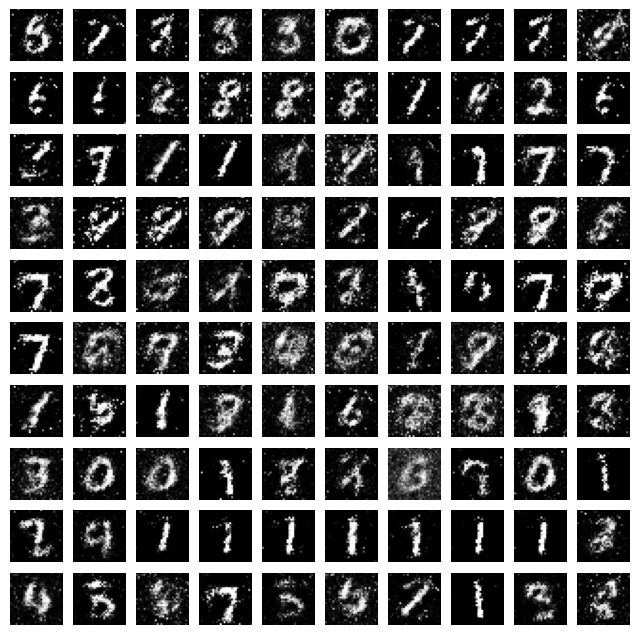

In [148]:
#generate images

num = 10
fig, axs = plt.subplots(10, num, figsize=(8, 8))

for i in range(10):
    original_images = x_test[y_test == i][:num]
    conditioning_vector = extract_center_patch(original_images)

    random_noise = np.random.normal(0, 1, (num, latent_dim))

    combined_input_example = np.concatenate([random_noise, conditioning_vector], axis=1)
    generated_images = generator.predict(combined_input_example)

    #generated images
    for j in range(num):
        axs[i, j].imshow(generated_images[j].reshape(28, 28), cmap='gray')
        axs[i, j].axis('off')

    #original images
    # for j in range(num):
    #     axs[i, num + j].imshow(original_images[j].reshape(28, 28), cmap='gray')
    #     axs[i, num + j].axis('off')

plt.show()